## MASZ projekt 8

Praca powstała poprzez współpracę Katarzyny Spalińskiej i Tomka Radzikowskiego. Dodatkowo korzystaliśmy z plików CSV udostępnionych dzięki uprzejmości Kolegi Roberta Jankowskiego

---

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import imageio

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Import danych

In [3]:
przystanki=pd.read_csv('data/all_stops.csv', error_bad_lines=False)
przystanki.head()

,ID,STREET_NAME,X,Y,BUS_TRAM_NO
0,100101,"Ul./Pl.: Targowa,",21.044827,52.248455,"['123', '125', '138', '146', '147', '166', '20..."
1,100102,"Ul./Pl.: Targowa,",21.044443,52.249078,"['138', '166', '509', 'N21', '509^']"
2,100103,"Ul./Pl.: Targowa,",21.043983,52.248998,"['3', '6', '7', '9^', '22^', '24^', '25', '26']"
3,100104,"Ul./Pl.: Targowa,",21.041726,52.249905,"['3', '6', '13', '20^', '23^', '25', '26', '28']"
4,100106,"Ul./Pl.: Kijowska,",21.043710,52.250008,"['3^', '6^', '7', '9^', '13', '20^', '22^', '2..."


In [4]:
linie=pd.read_csv('data/all_lines.csv', error_bad_lines=False)
linie.head()

,LINE_NUMBER,FROM,TO,FROM_STREET_NAME,TO_STREET_NAME
0,1,410804,410803,"Banacha,","Banacha,"
1,1,410803,400503,"Banacha,","Bitwy Warszawskiej 1920 r.,"
2,1,400503,400403,"Bitwy Warszawskiej 1920 r.,","Och-Teatr,"
3,1,400403,412103,"Och-Teatr,","Wawelska,"
4,1,412103,400307,"Wawelska,","pl.Narutowicza,"


In [5]:
linie['LINE_NUMBER'].unique()

array(['1', '2', '3', '4', '6', '7', '9', '10', '11', '13', '14', '15',
       '17', '18', '20', '22', '23', '24', '25', '26', '27', '28', '31',
       '33', '35', '41', '102', '103', '104', '105', '107', '108', '109',
       '110', '111', '112', '114', '115', '116', '117', '118', '119',
       '120', '121', '122', '123', '124', '125', '126', '127', '128',
       '129', '130', '131', '132', '133', '134', '135', '136', '138',
       '139', '140', '141', '142', '143', '145', '146', '147', '148',
       '149', '150', '151', '152', '153', '154', '155', '156', '157',
       '158', '159', '160', '161', '162', '163', '164', '165', '166',
       '167', '168', '169', '170', '171', '172', '173', '174', '175',
       '176', '177', '178', '179', '180', '181', '182', '183', '184',
       '185', '186', '187', '188', '189', '190', '191', '192', '193',
       '194', '195', '196', '197', '198', '199', '200', '201', '202',
       '203', '204', '206', '207', '208', '209', '210', '211', '212',
       '213

## Podział sieci na warstwy (autobusy i tramwaje)

In [6]:
tram_lines = ['1', '2', '3', '4', '6', '7', '9', '10', '11', '13', '14', '15',
       '17', '18', '20', '22', '23', '24', '25', '26', '27', '28', '31',
       '33', '35', '41']

In [7]:
ztm=linie.merge(przystanki[['ID','X','Y']], left_on='FROM', right_on='ID')
ztm['gps'] = list(zip(ztm.X, ztm.Y))
ztm_trams = ztm.loc[(ztm.LINE_NUMBER.isin(tram_lines))]
ztm_bus = ztm.loc[~(ztm.LINE_NUMBER.isin(tram_lines))]

In [8]:
ztm_bus['LINE_NUMBER'].unique()

array(['169', '135', '160', '190', 'N16', 'N21', 'N61', 'N66', 'N71',
       'N14', 'N45', 'N95', '102', '523', '173', '311', '158', 'N24',
       '111', '117', '146', '147', '507', 'N72', '127', '107', '116',
       '178', '180', '222', '503', '518', '175', 'N44', '103', '114',
       '156', '203', '250', '409', '712', 'N02', 'N46', '121', '303',
       '397', 'N41', 'N91', '321', '136', '104', '118', '132', '414',
       '204', '314', '105', '249', '112', 'N42', '743', '197', '713',
       'N52', '194', '716', '109', '155', '167', '128', 'N64', '162',
       '119', '131', '159', '185', 'N31', 'N33', 'N83', '108', 'N11',
       '192', '331', '139', '200', '217', '251', '339', '166', '402',
       'N03', '501', '171', 'N12', 'N13', 'N62', '110', 'N01', 'N43',
       '213', '123', '411', '140', '120', '240', '256', '145', '269',
       '500', '134', '326', '705', '735', '122', '201', '189', '184',
       '126', '176', '115', '143', '196', '225', '183', '514', '125',
       '142', '161',

In [9]:
trams_dict=ztm_trams.set_index('ID')[['X', 'Y']].T.apply(tuple).to_dict()
buses_dict=ztm_bus.set_index('ID')[['X', 'Y']].T.apply(tuple).to_dict()

### Warstwa sieci: Tramwaje - wszystkie linie w układzie geograficznym

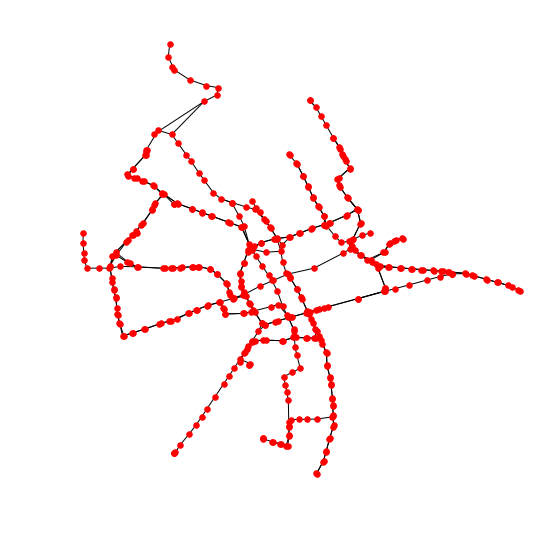

In [11]:
trams = nx.DiGraph()

trams.add_nodes_from(trams_dict.keys())

src=ztm_trams.loc[(ztm_trams.FROM.isin(ztm_trams.ID)) ,'FROM']
dst=ztm_trams.loc[(ztm_trams.TO.isin(ztm_trams.ID)) ,'TO']
ztm_trams_filtered=ztm_trams[(ztm_trams["TO"].isin(dst.values) & ztm_trams['FROM'].isin(src.values))]

trams.add_edges_from(list(zip(ztm_trams_filtered['FROM'].values, ztm_trams_filtered['TO'].values)))

for n, p in trams_dict.items():
    trams.nodes[n]['pos'] = p

plt.figure(figsize=(7, 7))
nx.draw(trams,trams_dict,node_size=30, arrows=False)
plt.show()

### Warstwa sieci: Autobusy - wszystkie linie w układzie geograficznym

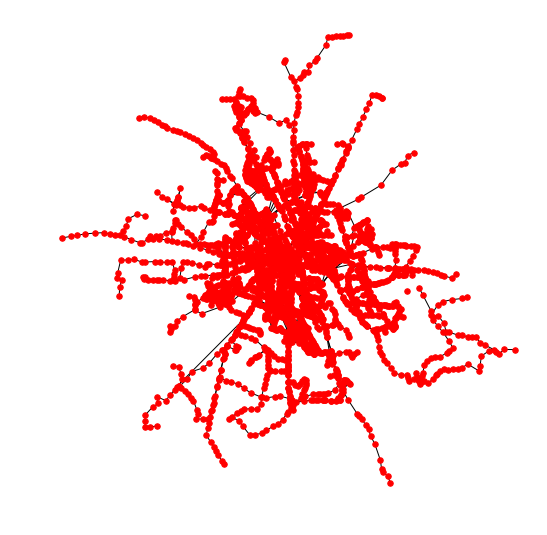

In [13]:
buses = nx.DiGraph()

buses.add_nodes_from(buses_dict.keys())

src=ztm_bus.loc[(ztm_bus.FROM.isin(ztm_bus.ID)) ,'FROM']
dst=ztm_bus.loc[(ztm_bus.TO.isin(ztm_bus.ID)) ,'TO']
ztm_bus_filtered=ztm_bus[(ztm_bus["TO"].isin(dst.values) & ztm_bus['FROM'].isin(src.values))]

buses.add_edges_from(list(zip(ztm_bus_filtered['FROM'].values, ztm_bus_filtered['TO'].values)))

for n, p in buses_dict.items():
    buses.nodes[n]['pos'] = p

plt.figure(figsize=(7, 7))
nx.draw(buses,buses_dict,node_size=30, arrows=False)
plt.show()

## Charakterystyki warstw sieci

Statystyki wczytane z pliku .py na podstawie projektu 4

In [10]:
from statistics import stats

### Statystyki dla sieci tramwajów:

In [11]:
# graf - tramwaje
trams = nx.DiGraph()
trams.add_nodes_from(trams_dict.keys())

src=ztm_trams.loc[(ztm_trams.FROM.isin(ztm_trams.ID)) ,'FROM']
dst=ztm_trams.loc[(ztm_trams.TO.isin(ztm_trams.ID)) ,'TO']
ztm_trams_filtered=ztm_trams[(ztm_trams["TO"].isin(dst.values) & ztm_trams['FROM'].isin(src.values))]

trams.add_edges_from(list(zip(ztm_trams_filtered['FROM'].values, ztm_trams_filtered['TO'].values)))

In [12]:
stats(trams)

Liczba węzłów: 436
Liczba krawędzi: 449
Średni stopień najbliższego węzła: 1.0400943396226414
Współczynnik korelacji: 0.20052355137906347
Współczynnik gronowania: None
Średni dystans: 8.362496045555204


### Statystyki dla sieci autobusów:

In [13]:
# graf - autobusy
buses = nx.DiGraph()
buses.add_nodes_from(buses_dict.keys())

src=ztm_bus.loc[(ztm_bus.FROM.isin(ztm_bus.ID)) ,'FROM']
dst=ztm_bus.loc[(ztm_bus.TO.isin(ztm_bus.ID)) ,'TO']
ztm_bus_filtered=ztm_bus[(ztm_bus["TO"].isin(dst.values) & ztm_bus['FROM'].isin(src.values))]

buses.add_edges_from(list(zip(ztm_bus_filtered['FROM'].values, ztm_bus_filtered['TO'].values)))

In [14]:
stats(buses)

Liczba węzłów: 3367
Liczba krawędzi: 3947
Średni stopień najbliższego węzła: 1.2317361950826278
Współczynnik korelacji: 0.22992332469015261
Współczynnik gronowania: None
Średni dystans: 28.480456568691864


----

## Sieci czasowe na przykładzie linii autobusowych

Dane z dni od 1 stycznia 2016 do 10 stycznia 2016 (po drodze święto 1 i 6 stycznia i soboty 2 i 9) - zebraliśmy numery/nazwy linii występujących w danym dniu lub nocy, po czym przedstawiliśmy w układzie geograficznym jak zmienia się zagęszczenie sieci w zależności od kolejnego dnia/nocy.

Informacje o tym jakie linie kursowały którego dnia były częścią wykorzystywanych danych, zaś ich opis udało się znaleźć pod linkiem https://www.ztm.waw.pl/wp-content/uploads/2014/04/1200_zasady.pdf w rozdziale "Opis sekcji" 

In [18]:
lines = {}
day_lines = {}
night_lines = {}

for i in range(1,11):
    print(i)
    lines[i] = pd.read_csv('data/stops_days_01_' + str(i) + '.txt', delimiter='   ', engine='python')
    lines_of_day = lines[i]['timetable_type'].unique()
    # wyświetlamy wszystkie linie danego dnia i nocy
    print(lines_of_day)
    # rozróżniamy linie dzienne i nocne, ponieważ wszystkie nocne zaczynają się od N
    day_lines[i] = lines[i].loc[~lines[i]['timetable_type'].isin([i for i in lines_of_day if i.startswith('N')])]
    night_lines[i] = lines[i].loc[lines[i]['timetable_type'].isin([i for i in lines_of_day if i.startswith('N')])]

1
['DS' 'NO' 'NP' 'NS' 'N5']
2
['SB' 'DS' 'NO' 'NP' 'NS' 'N6']
3
['DS' 'NO' 'NS']
4
['DP' 'NO' 'NS']
5
['DP' 'NO' 'N2' 'NS']
6
['DS' 'NO' 'NS']
7
['DP' 'NO' 'NS']
8
['DP' 'NO' 'NP' 'NS' 'N5']
9
['SB' 'DS' 'NO' 'NP' 'NS' 'N6']
10
['DS' 'D7' 'NO' 'NS']


### Autobusy - animacja na kolejnych dniach i nocach

In [19]:
for i in range(1,11):
    for daytime, day in zip([day_lines, night_lines], (True, False)):

        buses = nx.DiGraph()

        filtered_bus_numbers = lines[i].loc[lines[i]['timetable_type'].
                                            isin(daytime[i]['timetable_type'].unique())]['line'].unique()

        filtered_ztm_bus = ztm_bus.loc[ztm_bus['LINE_NUMBER'].isin(filtered_bus_numbers)]
        filtered_buses_dict=filtered_ztm_bus.set_index('ID')[['X', 'Y']].T.apply(tuple).to_dict()
        buses.add_nodes_from(filtered_buses_dict.keys())

        src = filtered_ztm_bus.loc[(filtered_ztm_bus.FROM.isin(filtered_ztm_bus.ID)) ,'FROM']
        dst = filtered_ztm_bus.loc[(filtered_ztm_bus.TO.isin(filtered_ztm_bus.ID)) ,'TO']
        final_ztm_bus = filtered_ztm_bus[(filtered_ztm_bus["TO"].isin(dst.values) & filtered_ztm_bus['FROM'].isin(src.values))]

        buses.add_edges_from(list(zip(final_ztm_bus['FROM'].values, final_ztm_bus['TO'].values)))


        for n, p in filtered_buses_dict.items():
            buses.nodes[n]['pos'] = p
        
        
        plt.figure(figsize=(7, 7))
        nx.draw(buses,filtered_buses_dict,node_size=30, arrows=False)
        if day:
            plt.title("Day "+str(i))
            plt.savefig("pictures/day_"+str(i)+'.png', bbox_inches='tight')
        else:
            plt.title("Night "+str(i))
            plt.savefig("pictures/night_"+str(i)+'.png', bbox_inches='tight')
        plt.close()

In [20]:
gif_path = "result.gif"
day_frames_path = "pictures/day_{i}.png"
night_frames_path = "pictures/night_{i}.png"

with imageio.get_writer(gif_path, mode='I', duration=1.5) as writer:
    for i in range(1,11):
        writer.append_data(imageio.imread(day_frames_path.format(i=i)))
        writer.append_data(imageio.imread(night_frames_path.format(i=i)))

### Metryki sieci w zależności od czasu

Przygotowanie grafu z wybranego dnia (3 stycznia 2016)

In [21]:
day_buses = nx.DiGraph()
filtered_bus_numbers = lines[3].loc[lines[3]['timetable_type'].
                                            isin(day_lines[i]['timetable_type'].unique())]['line'].unique()

filtered_ztm_bus = ztm_bus.loc[ztm_bus['LINE_NUMBER'].isin(filtered_bus_numbers)]
filtered_buses_dict=filtered_ztm_bus.set_index('ID')[['X', 'Y']].T.apply(tuple).to_dict()
day_buses.add_nodes_from(filtered_buses_dict.keys())

src = filtered_ztm_bus.loc[(filtered_ztm_bus.FROM.isin(filtered_ztm_bus.ID)) ,'FROM']
dst = filtered_ztm_bus.loc[(filtered_ztm_bus.TO.isin(filtered_ztm_bus.ID)) ,'TO']
final_ztm_bus = filtered_ztm_bus[(filtered_ztm_bus["TO"].isin(dst.values) & filtered_ztm_bus['FROM'].isin(src.values))]

day_buses.add_edges_from(list(zip(final_ztm_bus['FROM'].values, final_ztm_bus['TO'].values)))

In [22]:
stats(day_buses)

Liczba węzłów: 2737
Liczba krawędzi: 3036
Średni stopień najbliższego węzła: 1.152440542896277
Współczynnik korelacji: 0.19244204076692148
Współczynnik gronowania: None
Średni dystans: 25.683222736081465


In [23]:
night_buses = nx.DiGraph()
filtered_bus_numbers = lines[3].loc[lines[3]['timetable_type'].
                                            isin(night_lines[i]['timetable_type'].unique())]['line'].unique()

filtered_ztm_bus = ztm_bus.loc[ztm_bus['LINE_NUMBER'].isin(filtered_bus_numbers)]
filtered_buses_dict=filtered_ztm_bus.set_index('ID')[['X', 'Y']].T.apply(tuple).to_dict()
night_buses.add_nodes_from(filtered_buses_dict.keys())

src = filtered_ztm_bus.loc[(filtered_ztm_bus.FROM.isin(filtered_ztm_bus.ID)) ,'FROM']
dst = filtered_ztm_bus.loc[(filtered_ztm_bus.TO.isin(filtered_ztm_bus.ID)) ,'TO']
final_ztm_bus = filtered_ztm_bus[(filtered_ztm_bus["TO"].isin(dst.values) & filtered_ztm_bus['FROM'].isin(src.values))]

night_buses.add_edges_from(list(zip(final_ztm_bus['FROM'].values, final_ztm_bus['TO'].values)))

In [24]:
stats(night_buses)

Liczba węzłów: 1110
Liczba krawędzi: 1160
Średni stopień najbliższego węzła: 1.0690281562216166
Współczynnik korelacji: 0.13756395327251772
Współczynnik gronowania: None
Średni dystans: 20.280029082283367


-----

# Problem badawczy

Pomni przykładu włoskich elektrowni chcemy sprawdzić jak warszawska sieć zachowa się w przypadku potencjalnej celowej awarii. W naszym przykładem jest atak terrorystyczny, np. bomba o dużej sile rażenia pozostawiona na Dworcu Centralnym. Ze wszystkich opcji ataku terrorystycznego ten wydaje się dość prawdopodobny, albowiem Dworzec jest jednym z głównych punktów komunikacyjnych Warszawy, dodatkowo jest przystankiem pociągów krajowych, zatem atak na ten punkt powinien sparaliżować miasto. W naszym scenariuszu, ze względu na wiadomość o podłożeniu rzeczonej bomby, sztab kryzysowy zdecydował o zamknięciu wszystkich przystanków komunikacji w promieniu kilometra od Dworca. Chcemy sprawdzić na ile parametry sieci pozostaną podobne, w szczególności średnia długość drogi, jako parametr, który pozwala mierzyć efektywność komunikacji (szybkość przemieszczania się). 

W związku z powyższym znaleziono współrzędne geograficzne budynku Centralnego, stworzono funkcję, do przeliczania różnicy koordynatów na metry i usunięto przystanki w promieniu kilometra. Na wyrysowanym grafie nie widać specjalnej różnicy, jednak po pogłębionej analizie widać niewielką białą plamę na mapie komunikacji.

Należy też wziąć pod uwagę, że przeprowadzona symulacja nie bierze pod uwagę najważniejszego czynnika - ludzkiego. Istnieje duże ryzyko, że możliwości ewakuacji/powrotu do domu zostałyby ograniczone, poprzez wzbierającą falę paniki i nadmierne zwiększenie ruchu kołowego. 

In [28]:
from math import  radians, sqrt, sin, cos
from math import atan2

def coord2meters (lat1, lon1, lat2,  lon2):
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    a = sin((lat2-lat1) / 2)**2 + cos(lat1) * cos(lat2) * sin((lon2-lon1) / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = 6373 * c

    #print("Result:", distance)
    return (distance)

In [29]:
central_station_lon= 52.22882 
central_station_lat=21.00287
przystanki['dist']=przystanki\
            .apply(lambda row : coord2meters(central_station_lat,central_station_lon,row['X'], row['Y']), axis=1)

### Przystanki usunięte z sieci całego transportu:

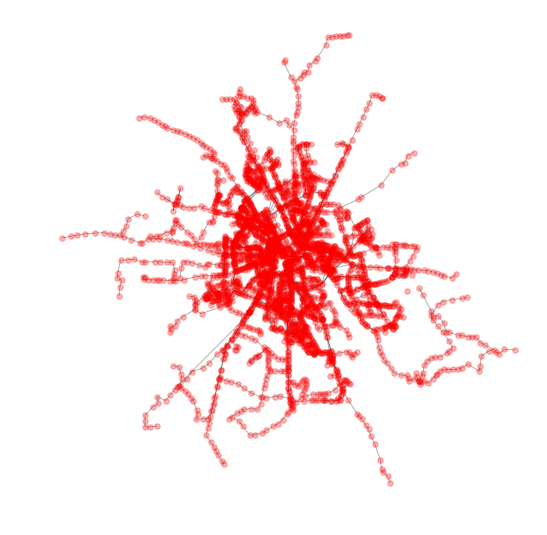

In [30]:
terrorist_attack_data=przystanki[(przystanki.dist>1)]
len(terrorist_attack_data)


ztm_pwnd=linie.merge(terrorist_attack_data[['ID','X','Y','dist']], left_on='FROM', right_on='ID')
ztm_pwnd['gps'] = list(zip(ztm_pwnd.X, ztm_pwnd.Y))
pwnd_dict=ztm_pwnd.set_index('ID')[['X', 'Y']].T.apply(tuple).to_dict()

attack = nx.DiGraph()

attack.add_nodes_from(pwnd_dict.keys())
src=ztm_pwnd.loc[(ztm_pwnd.FROM.isin(ztm_pwnd.ID)) ,'FROM']
dst=ztm_pwnd.loc[(ztm_pwnd.TO.isin(ztm_pwnd.ID)) ,'TO']
ztm_pwnd_filtered=ztm_pwnd[(ztm_pwnd["TO"].isin(dst.values) & ztm_pwnd['FROM'].isin(src.values))]

attack.add_edges_from(list(zip(ztm_pwnd_filtered['FROM'].values, ztm_pwnd_filtered['TO'].values)))

for n, p in pwnd_dict.items():
    attack.nodes[n]['pos'] = p

#trams1=nx.DiGraph(trams_dict)
plt.figure(figsize=(7, 7))
nx.draw(attack,pwnd_dict,node_size=30, arrows=False, node_color='red', alpha=.3)
plt.show()

### Przystanki usunięte z sieci tramwajów (aby graf był bardziej czytelny):

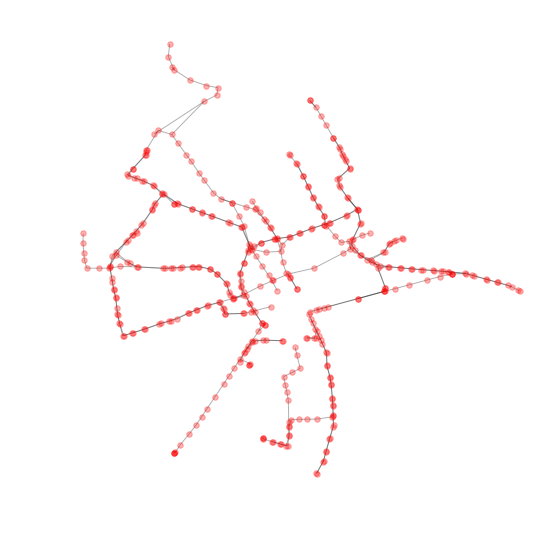

In [31]:
przystanki_tramwajowe = ztm.loc[(ztm.LINE_NUMBER.isin(tram_lines))]

przystanki_tramwajowe['dist']=przystanki_tramwajowe\
            .apply(lambda row : coord2meters(central_station_lat,central_station_lon,row['X'], row['Y']), axis=1)

terrorist_attack_data=przystanki_tramwajowe[(przystanki_tramwajowe.dist>1)]

ztm_pwnd=linie.merge(terrorist_attack_data[['ID','X','Y','dist']], left_on='FROM', right_on='ID')
ztm_pwnd['gps'] = list(zip(ztm_pwnd.X, ztm_pwnd.Y))
pwnd_dict=ztm_pwnd.set_index('ID')[['X', 'Y']].T.apply(tuple).to_dict()

attack = nx.DiGraph()

attack.add_nodes_from(pwnd_dict.keys())
src=ztm_pwnd.loc[(ztm_pwnd.FROM.isin(ztm_pwnd.ID)) ,'FROM']
dst=ztm_pwnd.loc[(ztm_pwnd.TO.isin(ztm_pwnd.ID)) ,'TO']
ztm_pwnd_filtered=ztm_pwnd[(ztm_pwnd["TO"].isin(dst.values) & ztm_pwnd['FROM'].isin(src.values))]

attack.add_edges_from(list(zip(ztm_pwnd_filtered['FROM'].values, ztm_pwnd_filtered['TO'].values)))

for n, p in pwnd_dict.items():
    attack.nodes[n]['pos'] = p

#trams1=nx.DiGraph(trams_dict)
plt.figure(figsize=(7, 7))
nx.draw(attack,pwnd_dict,node_size=30, arrows=False, node_color='red', alpha=.3)
plt.show()

### Statystyki na "popsutej" sieci tramwajów

Przypomnijmy jak przedstawiały się statystyki na oryginalnej sieci tramwajów:

In [25]:
stats(trams)

Liczba węzłów: 436
Liczba krawędzi: 449
Średni stopień najbliższego węzła: 1.0400943396226414
Współczynnik korelacji: 0.20052355137906347
Współczynnik gronowania: None
Średni dystans: 8.362496045555204


I porównajmy ze statystykami sieci po ataku:

In [32]:
stats(attack)

Liczba węzłów: 419
Liczba krawędzi: 424
Średni stopień najbliższego węzła: 1.02125
Współczynnik korelacji: 0.20157454658766616
Współczynnik gronowania: None


NetworkXError: Graph is not weakly connected.

Jak widać, średnia długość ścieżki nie została obliczona, ponieważ funkcja `average_shortest_path_length` może być obliczona tylko w przypadku, gdy graf jest spójny, co w tym przypadku nie jest spełnione. Istnieją węzły, pomiędzy którymi nie da się poprowadzić ścieżki, co było do przewidzenia - Dworzec Centralny i jego okoliczne przystanki, których brakuje w sieci tramwajów po ataku, są najbardziej "przesiadkowym" punktem na mapie Warszawy. Gdy go zabrakło, okazuje się, że nie da się znaleźć połączenia pomiędzy niektórymi węzłami.

------

Oświadczam, że niniejsza praca, stanowiąca podstawę do uznania osiągnięcia efektów uczenia się przedmiotu Modelowanie i Analiza Sieci Złożonych, została wykonana przez nas samodzielnie.

Tomasz Radzikowski, 259097

Katarzyna Spalińska, 269060